In [160]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

In [161]:
# read data into a pandas dataframe
# df = pd.read_csv('SCL_op.csv', parse_dates = ['time_stamp'])
df = pd.read_csv('ERCOT_op.csv', parse_dates = ['time_stamp'])

In [162]:
df.columns

Index([u'time_stamp', u'demand'], dtype='object')

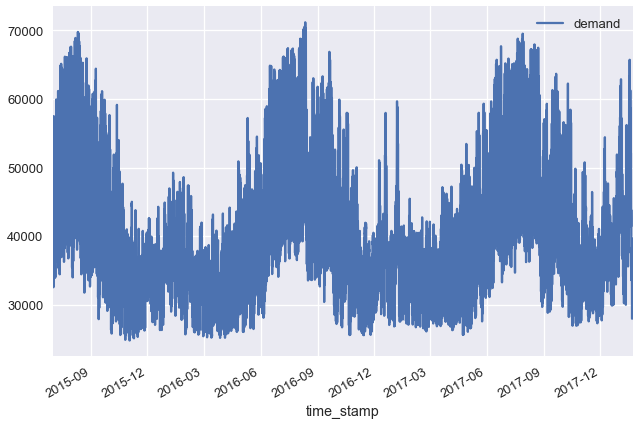

In [163]:
# plot ice extent over time
sns.set_context('talk')
df.plot(x=df.time_stamp, y='demand')

sns.despine()

One useful tool can be to plot the rolling mean, help you to visualize any trends over time. Additionally, it is smart to plot the standard deviation as a line graph to see if it deviates from a straight line.

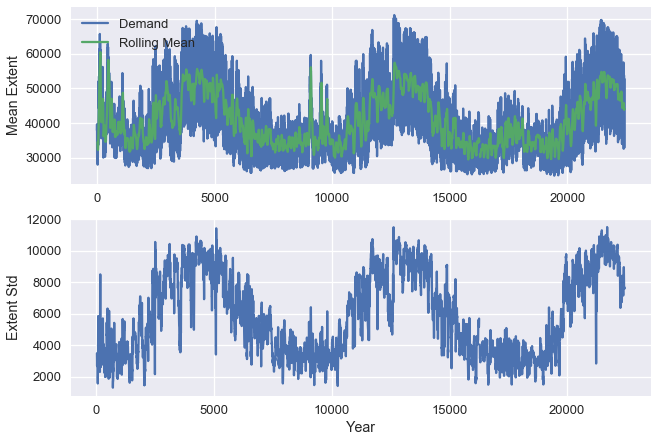

In [164]:
# calculate rolling mean: win = size of window to calculate over
# the window should usually be at least the size of your seasonal period (12 months here)
win = 24
rollMean = df.demand.rolling(window=win, center=False).mean()
rollStd = df.demand.rolling(window=win, center=False).std()

# plot the rolling stats
sns.set_context('talk')
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(df.demand, label='Demand')
ax1.plot(rollMean, label='Rolling Mean')
ax1.set_ylabel('Mean Extent')
ax1.legend()
ax2.plot(rollStd, label='Rolling Std')
ax2.set_xlabel('Year')
ax2.set_ylabel('Extent Std')
sns.despine()

In [165]:
from statsmodels.tsa.stattools import adfuller

In [166]:
dftest = adfuller(df.demand, autolag='AIC')

# the statsmodels output is ugly and unlabeled, lets use a function to format it nicely
def adf_output(dftest):
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# of Lags Used','Number of Observations Used'])

    # the last element is a dictionary to unpack
    for key,value in dftest[4].items(): 
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
adf_output(dftest)

LinAlgError: SVD did not converge

In this output we can see that the p-value is much larger that 0.05, confirming that the data are not stationary!

<a id='trend-removal'></a>
### Removing Trend to Make a Time Series Stationary

The simplest way to estimate and remove trend is to calculate a rolling mean and subtract it out:

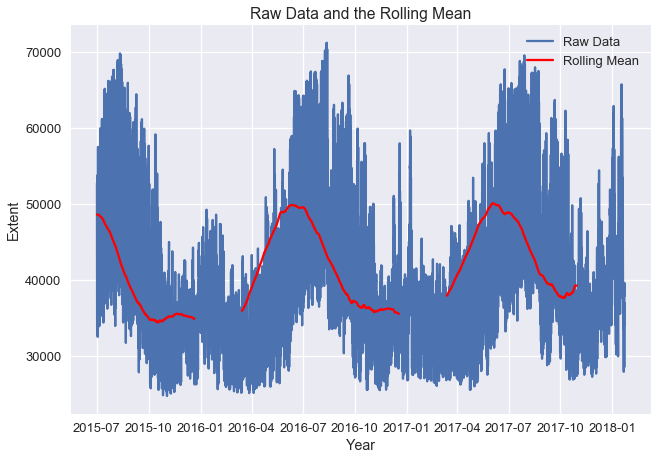

In [173]:
# calculate rolling mean
win = 24*7*12
rollMean = df.demand.rolling(window=win, center=False).mean()

# plot
sns.set_context('talk')
plt.plot(df.time_stamp, df.demand, label='Raw Data')
plt.plot(df.time_stamp, rollMean, color='red', label='Rolling Mean')
plt.xlabel('Year')
plt.ylabel('Extent')
plt.legend()
plt.title("Raw Data and the Rolling Mean")
sns.despine()

Notice that in the above plot, a few data points are missing from the front of the rolling mean time series. This is because of the window for calculating the moving average. We can remove those NAs and then detrend the time series. This loss of data is a good reason to keep the window as small as possible.

In [174]:
# subtract mean
demeaned = df.demand - rollMean
demeaned.dropna(inplace=True)

# did this do anything for our stationarity?
demeaned_adf = adfuller(demeaned, autolag='AIC')
adf_output(demeaned_adf)

Test Statistic                    -5.646150
p-value                            0.000001
# of Lags Used                    42.000000
Number of Observations Used    16342.000000
Critical Value (5%)               -2.861717
Critical Value (1%)               -3.430750
Critical Value (10%)              -2.566864
dtype: float64


**With the output above, you can see that this simple transformation made the data stationary. <br> Below, you can see that the moving average is now more stable.**

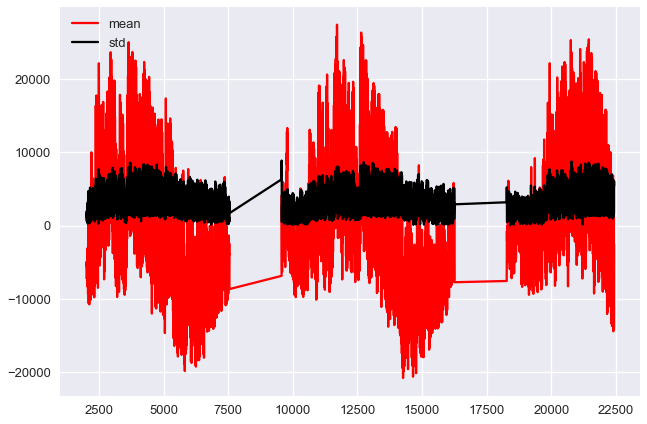

In [175]:
# rolling mean and std
win = 7
roll_demean = demeaned.rolling(window=win, center=False).mean()
roll_demean_std = demeaned.rolling(window=win, center=False).std()

# plot
plt.plot(roll_demean, color='red', label='mean')
plt.plot(roll_demean_std, color='black', label='std')
plt.legend(loc=2)
sns.despine()

**This is also apparent in the lack of decreasing trend in our demeaned time series**

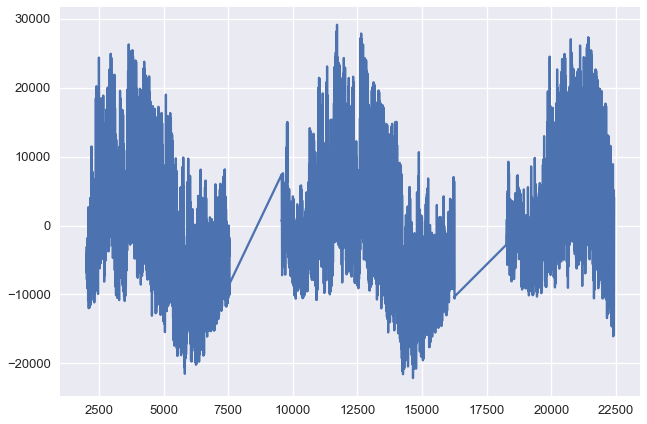

In [176]:
# plot the de-meaned time series
plt.plot(demeaned)
sns.despine()

<a id='differencing'></a>
### Differencing to Detrend

Another common method for removing trend is differencing. In this technique, you just subtract from your time series the time series shifted by t-1. Much like demeaning, this operation leaves you with just the change across time, which  often leads to a stationary series. You can then just model that change and superimpose it back on the trend.

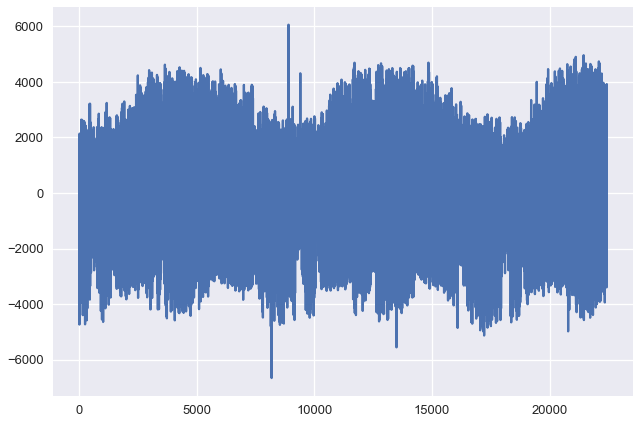

In [177]:
# construct difference curve and plot
diffed = df.demand - df.demand.shift()
diffed.dropna(inplace=True)
plt.plot(diffed)
sns.despine()

In [178]:
diffed_adf = adfuller(diffed, autolag='AIC')
adf_output(diffed_adf)

Test Statistic                   -23.701128
p-value                            0.000000
# of Lags Used                    47.000000
Number of Observations Used    22379.000000
Critical Value (5%)               -2.861669
Critical Value (1%)               -3.430642
Critical Value (10%)              -2.566839
dtype: float64


Differencing can also be useful when done multiple times, depending on the time series.

<br>

<a id='decomposition'></a>
### Decomposition - Modeling Trend and Season Separately

In [179]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [191]:
decomp = seasonal_decompose(df.demand.fillna(0.).values, model="additive", freq=24*7)

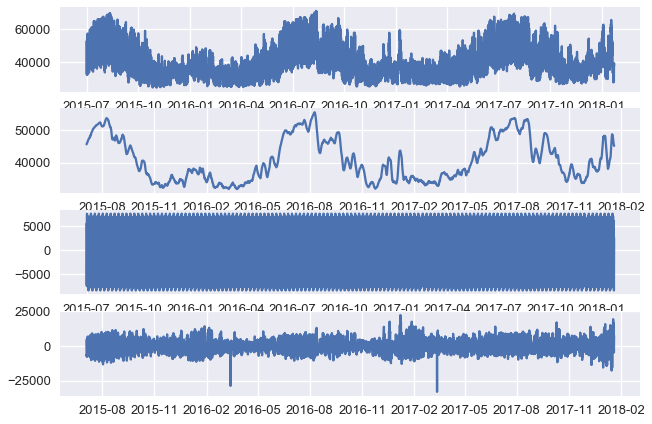

In [192]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)
ax1.plot(df.time_stamp, df.demand)
ax2.plot(df.time_stamp, decomp.trend)
ax3.plot(df.time_stamp, decomp.seasonal)
ax4.plot(df.time_stamp, decomp.resid)
sns.despine()

(736708.0, 736714.0)

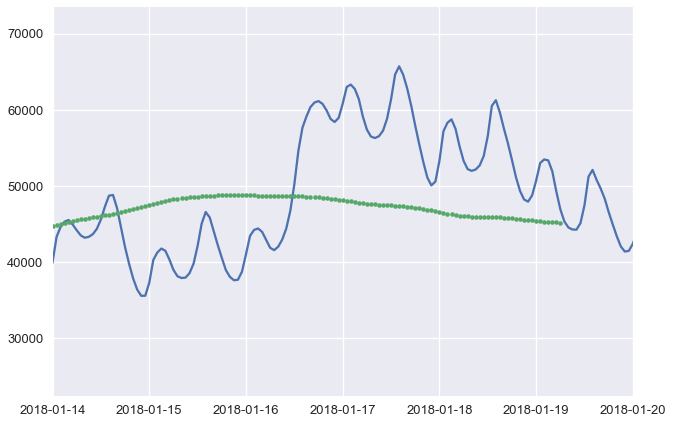

In [193]:
plt.plot(df.time_stamp, df.demand)
plt.plot(df.time_stamp, decomp.trend,'.')
plt.xlim(pd.datetime(2018,1,14), pd.datetime(2018,1,20))
#plt.ylim(0, 2000)

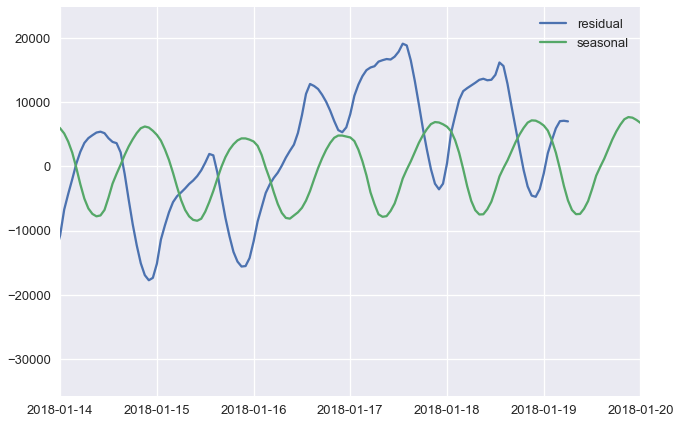

In [194]:
plt.plot(df.time_stamp, decomp.resid, label = 'residual')
plt.plot(df.time_stamp, decomp.seasonal, label = 'seasonal')
plt.xlim(pd.datetime(2018,1,14), pd.datetime(2018,1,20))
#plt.ylim(-5000, 5000)
plt.legend()

In [195]:
resid = decomp.resid#.dropna()
decomp_adf = adfuller(resid, autolag='AIC')
adf_output(decomp_adf)

LinAlgError: SVD did not converge